In [ ]:
!pip install keras_metrics owlready2 fasttext

from google.colab import drive
drive.mount("/content/drive")

import sys
sys.path.insert(0, '/content/drive/My Drive/Colab Notebooks')


     |████████████████████████████████| 20.8MB 1.4MB/s 
     |████████████████████████████████| 71kB 5.6MB/s 
  Created wheel for owlready2: filename=Owlready2-0.24-cp36-cp36m-linux_x86_64.whl size=20262991 sha256=5348f1ce6f566359a46c067edabb2bce87d13c96cf16c2046438dba913ceb3e2
  Stored in directory: /root/.cache/pip/wheels/66/87/0b/7a97bd19c9dc817b279aadb5dd920ce3a77050e2ab5a413f43
  Created wheel for fasttext: filename=fasttext-0.9.2-cp36-cp36m-linux_x86_64.whl size=3019975 sha256=7d202b99d7d7559514ebe024c5b1e9caee385e33b859a4e0e0fbf62825ec9ed7
  Stored in directory: /root/.cache/pip/wheels/98/ba/7f/b154944a1cf5a8cee91c154b75231136cc3a3321ab0e30f592
Successfully built owlready2 fasttext
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


DEBUG:matplotlib.pyplot:Loaded backend module://ipykernel.pylab.backend_inline version unknown.


# Création fichier paires négatives


In [ ]:
def nettoyer_unicode(c):
    liste_codes =  {
        'Ã\xa0': 'à',
        'Ã€': 'À',
        'Ã¢': 'â',
        'ã': 'â',
        'Ã‚': 'Â',
        'Ã©': 'é',
        'Ã©': 'é',
        'ã‰': 'é',
        'ãƒâ©': 'é',
        'Ã\x89': 'É',
        'Ã\xa8': 'è',
        'Ã\xaa': 'ê',
        'Ã\x8a': 'Ê', 
        'Ã¨': 'ê',       
        'Ã«': 'ë',
        'Ã®':'î',
        'Ã\x8e':'Î',        
        'Ã¯': 'ï', 
        'Ã´': 'ô',
        'Ã\x94': 'Ô',
        'Ã¹': 'ù', 
        'Ã»': 'û',
        'Å\x93': 'œ', 
        'Â«': '«',
        'Â»': '»',
        'Ã§': 'ç',
        'Ã\x87': 'Ç',
        'Âº': 'º',
        'â€™': '’',
        'â\x80\x99': '’',
        'â\x80\xa6' : '…',
    }
    
    for code in liste_codes:
        c = c.replace(code,liste_codes[code])
    return c

In [ ]:
import csv 
import numpy as np

paires_diff = []
with open("/content/drive/My Drive/Colab Notebooks/neg_results.csv") as f:
    reader = csv.DictReader(f)
    for row in reader:
      titre1_clean = nettoyer_unicode(row['title_raw1'])
      titre2_clean = nettoyer_unicode(row['title_raw2'])
      if (titre1_clean != titre2_clean): 
          paires_diff.append([titre1_clean, titre2_clean])
    print(len(paires_diff))
    np.save("/content/drive/My Drive/Colab Notebooks/paires_neg", paires_diff)

95882


In [ ]:
import numpy as np
from sklearn.utils import shuffle

#Paires positives
paires_pos = np.load("/content/drive/My Drive/Colab Notebooks/paires_pos.npy", allow_pickle = True)
# paires_pos = np.load("Desktop/paires_pos.npy", allow_pickle = True)

#Paires negatives
paires_neg = np.load("/content/drive/My Drive/Colab Notebooks/paires_neg.npy", allow_pickle = True)
# paires_neg = np.load("Desktop/paires_neg.npy", allow_pickle = True)

print(len(paires_pos), "paires positives")
print(len(paires_neg), "paires negatives")

#training
rand_pos_indices = np.random.choice(paires_pos.shape[0], 8250, replace=False)
training_data_pos = paires_pos[rand_pos_indices]
rand_neg_indices = np.random.choice(paires_neg.shape[0], 8250, replace=False)
training_data_neg = paires_neg[rand_neg_indices]

#training data
# formatter en X et Y pour CNN
id = []
titre1 = []
titre2 = []
for pair in training_data_neg:
  id.append(0)
  titre1.append(nettoyer_unicode(pair[0].lower()))
  titre2.append(nettoyer_unicode(pair[1].lower()))
for pair in training_data_pos:
  id.append(1)
  titre1.append(nettoyer_unicode(pair[0].lower()))
  titre2.append(nettoyer_unicode(pair[1].lower()))
train_data = shuffle(titre1, titre2, id)

#test
#get remaining pairs
remaining_pos_indices = np.array([x for x in np.arange(paires_pos.shape[0]) if not np.isin(x, rand_pos_indices)])
remaining_neg_indices = np.array([x for x in np.arange(paires_neg.shape[0]) if not np.isin(x, rand_neg_indices)])
remaining_pos = paires_pos[remaining_pos_indices]
remaining_neg = paires_neg[remaining_neg_indices]

#sélection aléatoire 500 paires positives et négatives
test_indices_pos = np.random.choice(remaining_pos.shape[0], 500, replace=False)
test_data_pos = remaining_pos[test_indices_pos]
test_indices_neg = np.random.choice(remaining_neg.shape[0], 500, replace=False)
test_data_neg = remaining_neg[test_indices_neg]

id = []
titre1 = []
titre2 = []
for pair in test_data_neg:
  id.append(0)
  titre1.append(nettoyer_unicode(pair[0].lower()))
  titre2.append(nettoyer_unicode(pair[1].lower()))
for pair in test_data_pos:
  id.append(1)
  titre1.append(nettoyer_unicode(pair[0].lower()))
  titre2.append(nettoyer_unicode(pair[1].lower()))
test_data = shuffle(titre1, titre2, id)


8950 paires positives
95882 paires negatives


Récupérer FastText

On réalise la tokenisation du texte

In [ ]:
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(filters=',"!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n\'', char_level=True, )
tokenizer.fit_on_texts(train_data[0] + train_data[1])
# tokenizer.fit_on_sequence

len_seq = 150
len_dict = len(tokenizer.word_counts) + 1
print(tokenizer.word_index)

#training data
train_data[0] = pad_sequences(tokenizer.texts_to_sequences(train_data[0]), maxlen=len_seq)
train_data[1] = pad_sequences(tokenizer.texts_to_sequences(train_data[1]), maxlen=len_seq)
print(train_data[0])
#concatenate word vectors
conc = []
for index, val in enumerate(train_data[0]):
  conc.append(np.concatenate([train_data[0][index], train_data[1][index]]))
train_data.append(conc)

#testing data
test_data[0] = pad_sequences(tokenizer.texts_to_sequences(test_data[0]), maxlen=len_seq)
test_data[1] = pad_sequences(tokenizer.texts_to_sequences(test_data[1]), maxlen=len_seq)

#concatenate word vectors
conc = []
for index, val in enumerate(test_data[0]):
  conc.append(np.concatenate([test_data[0][index], test_data[1][index]]))
test_data.append(conc)

# from keras.preprocessing.sequence import pad_sequences
# from keras.preprocessing.text import Tokenizer

# # tokenizer = Tokenizer(lower=True, filters=',"!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n\'' )
# tokenizer = Tokenizer(lower=True, filters=',"!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n\'', char_level=True, )
# tokenizer.fit_on_texts(train_data[0] + train_data[1])

# len_seq = 15
# len_dict = len(tokenizer.word_counts) + 1

# train_data[0] = pad_sequences(tokenizer.texts_to_sequences(train_data[0]), maxlen=len_seq)
# train_data[1] = pad_sequences(tokenizer.texts_to_sequences(train_data[1]), maxlen=len_seq)
# print(train_data[0])
# #concatenate word vectors
# conc = []
# for index, val in enumerate(train_data[0]):
#   conc.append(np.concatenate([train_data[0][index], train_data[1][index]]))
# train_data.append(conc)

# test_data[0] = pad_sequences(tokenizer.texts_to_sequences(test_data[0]), maxlen=len_seq)
# test_data[1] = pad_sequences(tokenizer.texts_to_sequences(test_data[1]), maxlen=len_seq)

# #concatenate word vectors
# conc = []
# for index, val in enumerate(test_data[0]):
#   conc.append(np.concatenate([test_data[0][index], test_data[1][index]]))
# test_data.append(conc)

# valid_data[0] = pad_sequences(tokenizer.texts_to_sequences(valid_data[0]), maxlen=len_seq)
# valid_data[1] = pad_sequences(tokenizer.texts_to_sequences(valid_data[1]), maxlen=len_seq)

# #concatenate word vectors
# conc = []
# for index, val in enumerate(valid_data[0]):
#   conc.append(np.concatenate([valid_data[0][index], valid_data[1][index]]))
# valid_data.append(conc)



DEBUG:tensorflow:Falling back to TensorFlow client; we recommended you install the Cloud TPU client directly with pip install cloud-tpu-client.


{' ': 1, 'e': 2, 'l': 3, 's': 4, 'a': 5, 'r': 6, 'i': 7, 'o': 8, 'n': 9, 't': 10, 'u': 11, 'd': 12, 'm': 13, 'c': 14, 'p': 15, 'é': 16, 'g': 17, 'h': 18, 'v': 19, 'b': 20, 'f': 21, "'": 22, '-': 23, 'è': 24, 'q': 25, ',': 26, 'j': 27, 'y': 28, '1': 29, 'x': 30, '2': 31, 'k': 32, 'à': 33, '.': 34, '!': 35, 'ê': 36, '3': 37, '0': 38, '(': 39, ')': 40, '/': 41, 'â': 42, 'z': 43, '4': 44, 'º': 45, ':': 46, '9': 47, 'ô': 48, '5': 49, '°': 50, '6': 51, '7': 52, 'î': 53, 'w': 54, '8': 55, 'œ': 56, ';': 57, 'ë': 58, 'ï': 59, '?': 60, '[': 61, ']': 62, 'ç': 63, '’': 64, 'û': 65, '&': 66, '#': 67, 'ã': 68, '=': 69, '\xa0': 70, 'ù': 71, '\x80': 72, 'ü': 73, '"': 74, '–': 75, '…': 76, '@': 77, 'í': 78, '¼': 79, 'å': 80, '\x92': 81, 'ö': 82, '_': 83, 'ä': 84, '«': 85, '»': 86, 'á': 87, '\n': 88, '\x88': 89, '+': 90, '\xad': 91, 'ó': 92, 'ñ': 93, '\x84': 94, '¶': 95, '*': 96, '½': 97, '£': 98, '%': 99, '̂': 100, '\x99': 101, '²': 102, '¿': 103, '¢': 104, 'š': 105, '³': 106}
[[ 0  0  0 ... 10  8  6]



On va maintenant utiliser Fasttext pour définir les embeddings

In [ ]:
import io
import os
import numpy as np

# si il n'existe pas déjà une matrice de crée
# characters
if not os.path.exists('/content/drive/My Drive/Colab Notebooks/weights_char_glove.npy'):
# if not os.path.exists('Desktop/weights.npy'):
  print('Computing character weights')
  embedding_vectors = {}
  fin = io.open('Desktop/cc.fr.300.vec', 'r', encoding='utf-8', newline='\n', errors='ignore')
  for line in fin:
    line_split = line.strip().split(" ")
    vec = np.array(line_split[1:], dtype=float)
    word = line_split[0]
    for char in word:
      if ord(char) < 128:
        if char in embedding_vectors:
          embedding_vectors[char] = (embedding_vectors[char][0] + vec, embedding_vectors[char][1] + 1)
        else:
          embedding_vectors[char] = (vec, 1)

  # with open('Desktop/weights.npy', 'w') as f2:
  #   for word in embedding_vectors:
  #       avg_vector = np.round(
  #           (embedding_vectors[word][0] / embedding_vectors[word][1]), 6).tolist()
  #       f2.write(word + " " + " ".join(str(x) for x in avg_vector) + "\n")
  embedding_matrix = np.zeros((128, 300))
  for i in range(128):
    embedding_vector = embedding_vectors.get(chr(i))
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

  np.save('Desktop/weights', embedding_vectors)
# m_embedding = np.load('Desktop/weights.npy')

# else:
#   # f = io.open('/content/drive/My Drive/Colab Notebooks/weights_char_fast.npy', 'r', encoding='utf-8', newline='\n')
#   m_embedding = np.load('/content/drive/My Drive/Colab Notebooks/weights_words.npy', allow_pickle=True)

# word vectors
if not os.path.exists('/content/drive/My Drive/Colab Notebooks/weights_words.npy'):
# if not os.path.exists('Desktop/weights_words.npy'):
    print('Computing weights')
    dictionnary = {}
    fin = io.open('Desktop/cc.fr.300.vec', 'r', encoding='utf-8', newline='\n', errors='ignore')
    n, d = map(int, fin.readline().split())
    for line in fin:
        tokens = line.rstrip().split(' ')
        dictionnary[tokens[0]] = np.asarray(tokens[1:], dtype='float32')

    m_embedding = np.zeros((len(tokenizer.word_counts) + 1, 300))
    count = 0
    for word, index in tokenizer.word_index.items():
      if word in dictionnary:
        m_embedding[index] = dictionnary[word]
      else:
        count += 1
        print('pas dans fasttext: {}'.format(word))
    np.save('Desktop/weights_words', m_embedding)
    print(count)
else:
    m_embedding = np.load('/content/drive/My Drive/Colab Notebooks/weights_words.npy')

Création du modèle

In [ ]:
from dataset_utils_2 import compute_max_length, preprocess_dataset, get_classes_weights
import pandas as pd
from sklearn.utils import shuffle
import numpy as np
from time import time
import tensorflow.keras as keras
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, GaussianNoise, BatchNormalization, Bidirectional, TimeDistributed
from keras.layers import Conv2D, AveragePooling1D, MaxPooling2D, Conv1D, MaxPooling1D, Embedding, LSTM
from keras_metrics import precision, recall, f1_score, binary_precision, binary_f1_score, binary_recall
from keras.callbacks import EarlyStopping, ModelCheckpoint
from imblearn.over_sampling import RandomOverSampler
from imblearn.keras import balanced_batch_generator
from nltk.metrics import edit_distance
from keras.utils import plot_model
import matplotlib.pyplot as plt

def createLSTM():
  model = Sequential([
    Embedding(len(tokenizer.word_counts) + 1, 64, input_length=len_seq * 2),
    Bidirectional(LSTM(64)),
    Dense(32, activation='relu'),
    Dense(1)])
  opt = keras.optimizers.Adam(lr=0.00001, beta_1=0.9, beta_2=0.999, decay=0.0, amsgrad=False)

  model.compile(loss='binary_crossentropy',
                optimizer=opt,
                metrics=['accuracy', binary_precision(), binary_recall(), binary_f1_score()])
  return model

def createCNN():
  model = Sequential()
  model.add(Embedding(128, 300, input_length=len_seq*2))
  
  model.add(Conv1D(64, 5, padding='same'))
  model.add(Activation('relu'))
  model.add(AveragePooling1D(pool_size=2))
  
  model.add(Conv1D(64, 5, padding='same'))
  model.add(Activation('relu'))
  model.add(AveragePooling1D(pool_size=2))
  
  model.add(Conv1D(64, 5, padding='same'))
  model.add(Activation('relu'))
  model.add(AveragePooling1D(pool_size=2))
  
  model.add(Conv1D(64, 5, padding='same'))
  model.add(Activation('relu'))
  model.add(AveragePooling1D(pool_size=2))
  
  model.add(Conv1D(64, 5, padding='same'))
  model.add(Activation('relu'))
  model.add(AveragePooling1D(pool_size=2, padding='same'))
  
  model.add(Conv1D(64, 5, padding='same'))
  model.add(Activation('relu'))
  model.add(AveragePooling1D(pool_size=2, padding='same'))

  model.add(BatchNormalization())

  model.add(Flatten())
  model.add(Dense(300))
  model.add(Activation('relu'))
  model.add(Dense(1))
  model.add(Activation('sigmoid'))  
  
  opt = keras.optimizers.Adam(lr=0.00001, beta_1=0.9, beta_2=0.999, decay=0.0, amsgrad=False)

  model.compile(loss='binary_crossentropy',
                optimizer=opt,
                metrics=['accuracy', binary_precision(), binary_recall(), binary_f1_score()])
  return model


def create_model(input_length, embedding):
  model = Sequential()
  model.add(Embedding(128, 300, input_length=input_length, weights=[embedding]))
  model.add(Conv1D(64, 5, padding='same'))
  model.add(Activation('relu'))
  model.add(Conv1D(64, 5, padding='same'))
  model.add(Activation('relu'))
  model.add(AveragePooling1D(pool_size=2))
  
  model.add(Conv1D(64, 5, padding='same'))
  model.add(Activation('relu'))
  model.add(Conv1D(64, 5, padding='same'))
  model.add(Activation('relu'))
  model.add(AveragePooling1D(pool_size=2))
  
  model.add(Conv1D(64, 5, padding='same'))
  model.add(Activation('relu'))
  model.add(Conv1D(64, 5, padding='same'))
  model.add(Activation('relu'))
  model.add(AveragePooling1D(pool_size=2))
  
  model.add(Conv1D(64, 5, padding='same'))
  model.add(Activation('relu'))
  model.add(Conv1D(64, 5, padding='same'))
  model.add(Activation('relu'))
  model.add(AveragePooling1D(pool_size=2, padding='same'))
  
  model.add(Conv1D(64, 5, padding='same'))
  model.add(Activation('relu'))
  model.add(Conv1D(64, 5, padding='same'))
  model.add(Activation('relu'))
  model.add(AveragePooling1D(pool_size=2, padding='same'))
  
  model.add(Conv1D(64, 5, padding='same'))
  model.add(Activation('relu'))
  model.add(Conv1D(64, 5, padding='same'))
  model.add(Activation('relu'))
  model.add(AveragePooling1D(pool_size=2, padding='same'))
  
  model.add(Conv1D(64, 5, padding='same'))
  model.add(Activation('relu'))
  model.add(Conv1D(64, 5, padding='same'))
  model.add(Activation('relu'))
  model.add(AveragePooling1D(pool_size=2, padding='same'))
  
  model.add(Conv1D(64, 5, padding='same'))
  model.add(Activation('relu'))
  model.add(Conv1D(64, 5, padding='same'))
  model.add(Activation('relu'))

  model.add(BatchNormalization())

  model.add(Flatten())
  model.add(Dense(500))
  model.add(Activation('relu'))
  model.add(Dense(500))
  model.add(Activation('relu'))
  model.add(Dense(500))
  model.add(Activation('relu'))
  model.add(Dense(500))
  model.add(Activation('relu'))
  model.add(Dense(500))
  model.add(Activation('relu'))
  model.add(Dense(500))
  model.add(Activation('relu'))
  model.add(Dense(500))
  model.add(Activation('relu'))
  model.add(Dense(500))
  model.add(Activation('relu'))
  model.add(Dense(500))
  model.add(Activation('relu'))
  model.add(Dense(500))
  model.add(Activation('relu'))
  model.add(Dense(1))
  model.add(Activation('sigmoid'))

  opt = keras.optimizers.Adam(lr=0.00001, beta_1=0.9, beta_2=0.999, decay=0.0, amsgrad=False)

  model.compile(loss='binary_crossentropy',
                optimizer=opt,
                metrics=['accuracy', binary_precision(), binary_recall(), binary_f1_score()])
  return model


def create_model(input_length, embedding):
  model = Sequential()
  model.add(Embedding(128, 300, input_length=input_length))
  # model.add(Embedding(9894, 300, input_length=input_length, weights=[embedding]))
  model.add(Conv1D(64, 5, padding='same'))
  model.add(Activation('relu'))
  model.add(Conv1D(64, 5, padding='same'))
  model.add(Activation('relu'))
  model.add(AveragePooling1D(pool_size=2))
  
  model.add(Conv1D(64, 5, padding='same'))
  model.add(Activation('relu'))
  model.add(Conv1D(64, 5, padding='same'))
  model.add(Activation('relu'))
  model.add(AveragePooling1D(pool_size=2))
  
  model.add(Conv1D(64, 5, padding='same'))
  model.add(Activation('relu'))
  model.add(Conv1D(64, 5, padding='same'))
  model.add(Activation('relu'))
  model.add(AveragePooling1D(pool_size=2))
  
  model.add(Conv1D(64, 5, padding='same'))
  model.add(Activation('relu'))
  model.add(Conv1D(64, 5, padding='same'))
  model.add(Activation('relu'))
  model.add(AveragePooling1D(pool_size=2, padding='same'))
  
  model.add(Conv1D(64, 5, padding='same'))
  model.add(Activation('relu'))
  model.add(Conv1D(64, 5, padding='same'))
  model.add(Activation('relu'))
  model.add(AveragePooling1D(pool_size=2, padding='same'))
  
  model.add(Conv1D(64, 5, padding='same'))
  model.add(Activation('relu'))
  model.add(Conv1D(64, 5, padding='same'))
  model.add(Activation('relu'))
  model.add(AveragePooling1D(pool_size=2, padding='same'))
  
  model.add(Conv1D(64, 5, padding='same'))
  model.add(Activation('relu'))
  model.add(Conv1D(64, 5, padding='same'))
  model.add(Activation('relu'))
  model.add(AveragePooling1D(pool_size=2, padding='same'))
  
  model.add(Conv1D(64, 5, padding='same'))
  model.add(Activation('relu'))
  model.add(Conv1D(64, 5, padding='same'))
  model.add(Activation('relu'))

  model.add(BatchNormalization())

  model.add(Flatten())
  model.add(Dense(500))
  model.add(Activation('relu'))
  model.add(Dense(500))
  model.add(Activation('relu'))
  model.add(Dense(500))
  model.add(Activation('relu'))
  model.add(Dense(500))
  model.add(Activation('relu'))
  model.add(Dense(500))
  model.add(Activation('relu'))
  model.add(Dense(500))
  model.add(Activation('relu'))
  model.add(Dense(500))
  model.add(Activation('relu'))
  model.add(Dense(500))
  model.add(Activation('relu'))
  model.add(Dense(500))
  model.add(Activation('relu'))
  model.add(Dense(500))
  model.add(Activation('relu'))
  model.add(Dense(1))
  model.add(Activation('sigmoid'))

  opt = keras.optimizers.Adam(lr=0.00001, beta_1=0.9, beta_2=0.999, decay=0.0, amsgrad=False)

  model.compile(loss='binary_crossentropy',
                optimizer=opt,
                metrics=['accuracy', binary_precision(), binary_recall(), binary_f1_score()])
  return model

def train(model, train_data):
    nb_examples = len(train_data)
    x_train = np.array(train_data[3])
    y_train = np.array(train_data[2])

    es = EarlyStopping(monitor='val_loss', min_delta=0, patience=2, verbose=1, mode='min')
    cp = ModelCheckpoint("model.h5", save_best_only=True, monitor='val_loss', mode='min')

    # neg_weight = 40

    history = model.fit(x=x_train,
              y=y_train,
              epochs=100,
              batch_size=64,
              validation_split=0.1,
              # class_weight={0: neg_weight, 1: 1},
              callbacks=[es, cp])
    
    print(history.history.keys())
    # history for precision
    plt.plot(history.history['precision'])
    plt.plot(history.history['val_precision'])
    plt.title('model precision')
    plt.ylabel('precision')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

def test_model(model, test_datasets, distances=None):
    for i, ds in enumerate(test_datasets):
        x_test = np.array(test_data[3])
        y_test = np.array(test_data[2])

        preds = model.predict_on_batch(x_test)
        preds = [1 if preds[i][0] > 0.1 else 0 for i in range(preds.shape[0])]
        tp_ = tp(preds, y_test)
        fp_ = fp(preds, y_test)
        fn_ = fn(preds, y_test)
        p = precision(tp_, fp_)
        r = recall(tp_, fn_)
        f1 = f1_score(p, r)

        print(f"tp: {tp_}, nb_pos: {len([1 for y in y_test if y == 1])}")
        print(f"fp: {fp_}, nb_pos: {len([1 for y in y_test if y == 1])}")
        print(f"fn: {fn_}, nb_neg: {len([1 for y in y_test if y == 0])}")
        print(f"precision: {p}, recall: {r}, f1: {f1}")
    
        if distances:
            thresh = 1
            preds = [preds[j] if distances[i][j] < thresh else 0 for j in range(len(preds))]
            tp_ = tp(preds, y_test)
            fp_ = fp(preds, y_test)
            fn_ = fn(preds, y_test)
            p = precision(tp_, fp_)
            r = recall(tp_, fn_)
            f1 = f1_score(p, r)

            print(f"tp: {tp_}, nb_pos: {len([1 for y in y_test if y == 1])}")
            print(f"fp: {fp_}, nb_pos: {len([1 for y in y_test if y == 1])}")
            print(f"fn: {fn_}, nb_neg: {len([1 for y in y_test if y == 0])}")
            print(f"better: precision: {p}, recall: {r}, f1: {f1}")
            
def tp(preds, targets):
    tp = len([1 for i in range(len(preds)) if preds[i] == 1 and targets[i] == 1])
    
    return tp

def fp(preds, targets):
    fp = len([1 for i in range(len(preds)) if preds[i] == 1 and targets[i] == 0])
    
    return fp

def tn(preds, targets):
    tn = len([1 for i in range(len(preds)) if preds[i] == 0 and targets[i] == 0])

def fn(preds, targets):
    fn = len([1 for i in range(len(preds)) if preds[i] == 0 and targets[i] == 1])
    return fn
    
def precision(tp_, fp_):    
    return tp_ / (tp_ + fp_)

def recall(tp_, fn_):
    return tp_ / (tp_ + fn_)

def f1_score(p, r):
    return 2 * p * r / (p + r)


/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.utils.testing module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from s

Epoch 1/100
233/233 [==============================] - 100s 430ms/step - loss: 0.6610 - accuracy: 0.6538 - precision: 0.7568 - recall: 0.3747 - f1_score: 0.4664 - val_loss: 0.6836 - val_accuracy: 0.5127 - val_precision: 0.5105 - val_recall: 0.9813 - val_f1_score: 0.6716
Epoch 2/100
233/233 [==============================] - 99s 426ms/step - loss: 0.6001 - accuracy: 0.6939 - precision: 0.7399 - recall: 0.5825 - f1_score: 0.6515 - val_loss: 0.6416 - val_accuracy: 0.7036 - val_precision: 0.7320 - val_recall: 0.6951 - val_f1_score: 0.7128
Epoch 3/100
233/233 [==============================] - 101s 432ms/step - loss: 0.5743 - accuracy: 0.7156 - precision: 0.7804 - recall: 0.5978 - f1_score: 0.6768 - val_loss: 0.5866 - val_accuracy: 0.7267 - val_precision: 0.7390 - val_recall: 0.7405 - val_f1_score: 0.7396
Epoch 4/100
233/233 [==============================] - 100s 430ms/step - loss: 0.5489 - accuracy: 0.7339 - precision: 0.7682 - recall: 0.6576 - f1_score: 0.7085 - val_loss: 0.5482 - val_ac

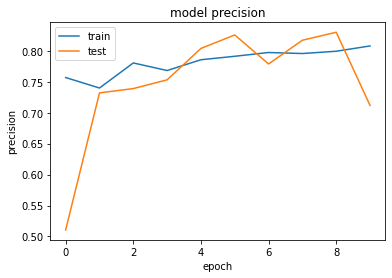

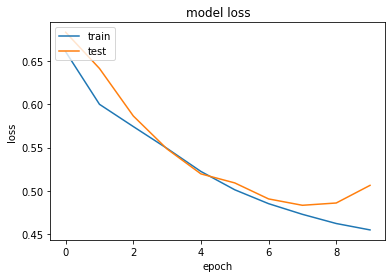

In [ ]:
if __name__ == '__main__':  

  # BiLSTM
  bilstm = createLSTM()
  train(bilstm, train_data)
  test_model(bilstm, test_data)

  #CNN light
  cnn = createCNN()
  train(cnn, train_data)
  test_model(cnn, test_data)

  #CNN ALexandre no weights
  # model = create_model()
  # train(model, train_data)
  test_model(model, test_data)
  # model.save("model_test_full_2.h5")
